# Cours : Régression

## Introduction

Avant de rentrer dans le coeur du cours, nous commencerons par revenir sur les données quantitatives multi-variées et leurs propriétés statistiques croisées, en particulier sur les notions de **covariance et corrélation** qui seront exploitées en régression linéaire. 

Nous présenterons alors le cadre général de la régression qui consiste à prédire une variable quantitative dite dépendante à partir des variables dépendantes d'une donnée.
Dans le cas de la **régression linéaire** cette prédiction prendra la forme d'une combinaison linéaire. Nous décrirons aussi la **régression par plus proches voisins**.
Nous illustrerons cette première partie sur des données provenant de la base [CIQUAL](https://pro.anses.fr/TableCIQUAL/index.htm) qui donne la composition nutritionnelle (58 paramètres) pour 1496 aliments. Nous nous contenterons ici des 4 caractères suivants :'Protéines (g/100g)','Glucides (g/100g)','Energie (kcal/100g)' et 'Lipides (g/100g)'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

## Nuages de points - Variance - Covariance - Corrélation

### Nuages de points

Importons les données extraites de la table CIQUAL:

In [2]:
res=pd.read_csv("CIQUAL.csv",encoding="cp1252",sep=";",decimal=",",header=0)
#dans le fichier csv d'origine téléchargeable sur la page indiquée plus haut il a été nécessaire de : 
#remplacer les ',' par des '.' dans les valeurs en flottant
#remplacer '<' par ''
#remplacer 'traces' par '0'

print(type(res))
print(np.shape(res))
names=np.array(res.columns)
index_of_interest=[13,14,2,18]
aliments_names=res.values[:,0]
X=np.array(res.values[:,index_of_interest],dtype=float)
N,p=np.shape(X)
features_names_vrais=names[index_of_interest]
print(features_names_vrais)
features_names=['Protéines','Glucides','Energie','Lipides']

<class 'pandas.core.frame.DataFrame'>
(939, 19)
[' Protéines' ' Glucides' ' Energie' ' Lipides']


In [3]:
print(aliments_names)

['Cervelle, agneau, cuite' 'Cervelle, porc, braisée'
 'Cervelle, veau, cuite' 'Coeur, agneau, cru' 'Coeur, agneau, cuit'
 'Coeur, boeuf, cru' 'Coeur, boeuf, cuit' 'Coeur, dinde, cru'
 'Coeur, dinde, cuit' 'Coeur, poulet, cru' 'Coeur, poulet, cuit'
 'Foie, agneau, cru' 'Foie, agneau, cuit' 'Foie, génisse, cru'
 'Foie, génisse, cuit' 'Foie, poulet, cuit' 'Foie, veau, cru'
 'Foie, veau, cuit' 'Foie, volaille, cuit'
 'Gésier, canard, confit, appertisé' 'Langue, boeuf, crue'
 'Langue, boeuf, cuite' 'Langue, veau, cuite' 'Ris, veau, braisé ou poêlé'
 "Rognon d'agneau, braisé" 'Rognon de veau, braisé ou poêlé'
 'Rognon, boeuf, cru' 'Rognon, boeuf, cuit' 'Rognon, cuit (aliment moyen)'
 'Rognon, porc, cuit' 'Lait de croissance infantile' 'Graisse de canard'
 "Graisse d'oie" 'Huile de foie de morue' 'Huile de poisson'
 'Lard gras, cru' 'Saindoux' 'Beurre allégé (aliment moyen)'
 'Beurre allégé, 60062% MG' 'Beurre allégé, 60062% MG, demi0sel'
 'Beurre demi0sel' 'Beurre doux' 'Beurre léger, 39041%

Puis représentons ces données dans chacun des plans des paramètres pris 2 à 2.

<IPython.core.display.Javascript object>


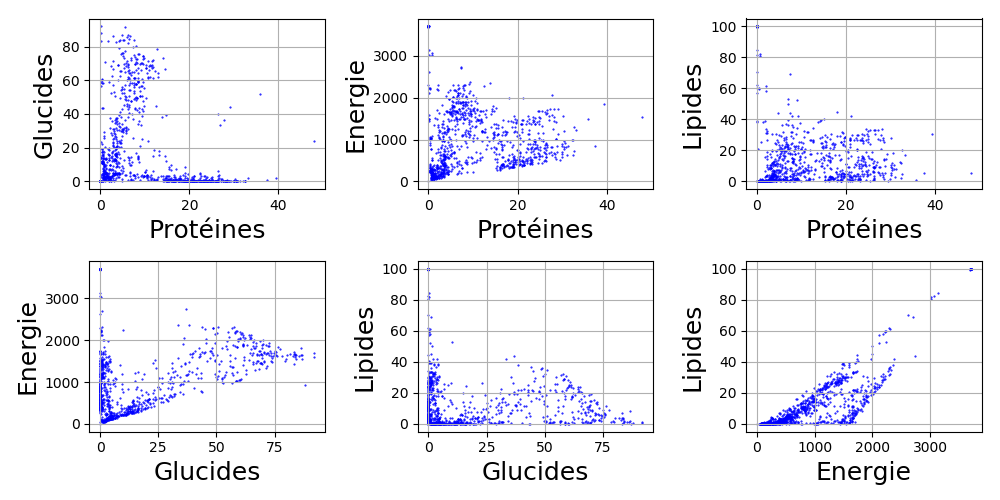

In [4]:
def plot_croises(X):
    N,p=np.shape(X)
    if p%2:
        nrows=int((p-1)/2)
        ncols=p
    else:
        nrows=int(p/2)
        ncols=p-1
        
    k=1
    plt.figure(figsize=(10,5))
    for i in range(p-1):
        for j in range(i+1,p):
            plt.subplot(nrows,ncols,k)
            plt.scatter(X[:,i],X[:,j],c='b',marker ='.',s=1) #,lw = 0)
            plt.ylabel(features_names[j],fontsize=18)
            plt.xlabel(features_names[i],fontsize=18)
            k=k+1
            plt.grid()
    plt.tight_layout()  
plot_croises(X)

On peut faire quelques remarques sur ces nuages: 
- Il n'y a pas (ou peu) d'aliments qui aient à la fois beaucoup de lipides (ou protéines) et beaucoup de glucides
- Quand les quantités de protéines ou de glucides ou surtout de lipides augmentent la valeur énergétique augmente elle aussi.
- Il ne semble pas y avoir de lien fort entre les quantités de protéines et de lipides.

Par ailleurs on a bien envie de se débarrasser du point qui a une quantité de protéines gigantesque et qui ruine un peu la visualisation des nuages

In [5]:
ind_prot_max=np.argmax(X[:,0])
ind=np.arange(N)
print(aliments_names[ind_prot_max])
X=X[ind!=ind_prot_max,:]
N,p=np.shape(X)

Levure alimentaire


Ces remarques sur les nuages de points peuvent en partie être quantifiées par les mesures de covariance entre paramètres.

### Variance (Rappel)

On rappelle que pour une variable aléatoire X la variance est définie par : 
$$Var(X)=E((X-E(X))^2)$$ et que si l'on dispose de N réalisations $x_i$ d'une telle variable, l'estimateur non biaisé de cette variance est : $$\widehat{Var}(X)=\frac{1}{N-1}\sum_{i=1}^{N}\left (x_i - \bar{x}  \right )^{2}$$ où $\bar{x}=\frac{1}{N}\sum_{i=1}^{N}x_i$ est l'estimée non biaisée de E(X).

$Var(X)$ est souvent notée $\sigma _{X}^{2}$. Sa racine carrée est l'écart type $\sigma _{X}$.

Examinons ces valeurs de moyenne et variance sur la base CIQUAL

In [6]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
print(features_names)
print('Moyenne des caractères',np.mean(X,0))
print('Variance des caractères',np.var(X,0))

['Protéines', 'Glucides', 'Energie', 'Lipides']
Moyenne des caractères [ 10.43  18.58  978.48  12.74]
Variance des caractères [ 82.76  620.81  556721.91  335.23]


Nous observons que les paramètres ne recouvrent pas du tout les mêmes étendues mais, en gros, l'écart type d'un paramètre est de l'ordre de grandeur de sa moyenne.


Illustration pour la valeur énergétique: 

<IPython.core.display.Javascript object>


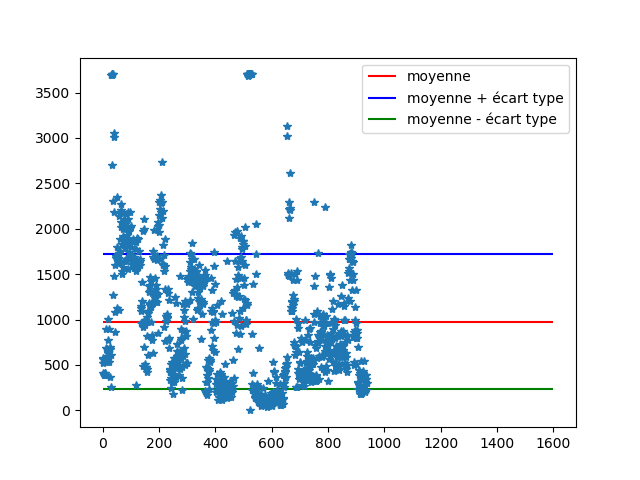

In [51]:
plt.figure()
plt.plot(X[:,2],'*')
m2=np.mean(X[:,2])
s2=np.std(X[:,2])
plt.hlines(m2,1,1600,color='red',label='moyenne')
plt.hlines(m2+s2,1,1600, color='blue',label='moyenne + écart type')
plt.hlines(m2-s2,1,1600, color='green',label='moyenne - écart type')   
plt.legend(fontsize=10)

Voyons maintenant le lien des paramètres pris 2 à 2.

### Covariance - Corrélation

Pour deux variables aléatoires X et Y on définit la covariance par:
$$cov(X,Y)=E((X-E(X))(Y-E(Y)))$$ et l'estimée de cette covariance: $$\widehat{Cov}(X,Y)=\frac{1}{N-1}\sum_{n=1}^{N}\left (x_n - \bar{x}  \right )\left ( y_n-\bar{y} \right ).$$

Pour un vecteur aléatoire $\mathbf{X}=(X_1, ..., X_j,...,X_p)$ on peut donc définir une matrice de covariance notée $\mathbf{C}$ dont le terme en i-ème ligne j-ème colonne comportera le terme de covariance $cov(X_i,X_j)$. 

Pour N réalisations d'un tel vecteur on accèdera à une estimée de la matrice de covariance par les opérations simples suivantes:
- centrer les données : retirer la moyenne de chaque caractère à toutes les données relatives à ce caractère 

In [8]:
Xc=X-np.mean(X,0) 
# matlab n'aimerait pas trop ce genre d'écriture matrice - vecteur mais Python s'en accomode


- faire le produit de cette matrice centrée transposée avec elle même non transposée puis appliquer le facteur 1/(N-1).

In [9]:
C_est=np.dot(Xc.T,Xc)/(N-1)
print(features_names)
print('Estimée de la matrice de covariance\n',C_est)

['Protéines', 'Glucides', 'Energie', 'Lipides']
Estimée de la matrice de covariance
 [[ 82.85 -71.46  42.95 -2.40]
 [-71.46  621.48  7694.34 -50.84]
 [ 42.95  7694.34  557316.07  11458.04]
 [-2.40 -50.84  11458.04  335.59]]


On reconnait les variances des paramètres sur la diagonale de cette matrice.

Encore plus simple avec la fonction cov de python

In [10]:
C=np.cov(X.T)
print(features_names)
print('Matrice de Covariance issue de la fonction cov Python\n',C)


['Protéines', 'Glucides', 'Energie', 'Lipides']
Matrice de Covariance issue de la fonction cov Python
 [[ 82.85 -71.46  42.95 -2.40]
 [-71.46  621.48  7694.34 -50.84]
 [ 42.95  7694.34  557316.07  11458.04]
 [-2.40 -50.84  11458.04  335.59]]


Il apparait:
- une faible covariance négative entre les quantités de protéines et glucides ainsi qu'entre glucides et lipides.
- une forte covariance positive entre la quantité de glucides et la valeur énergétique 
- une forte covariance positive entre la quantité de lipides et la valeur énergétique 
- une faible covariance positive entre la quantité de protéines et la quantité de glucides 

Regardons de nouveaux les nuages "centrés"

<IPython.core.display.Javascript object>


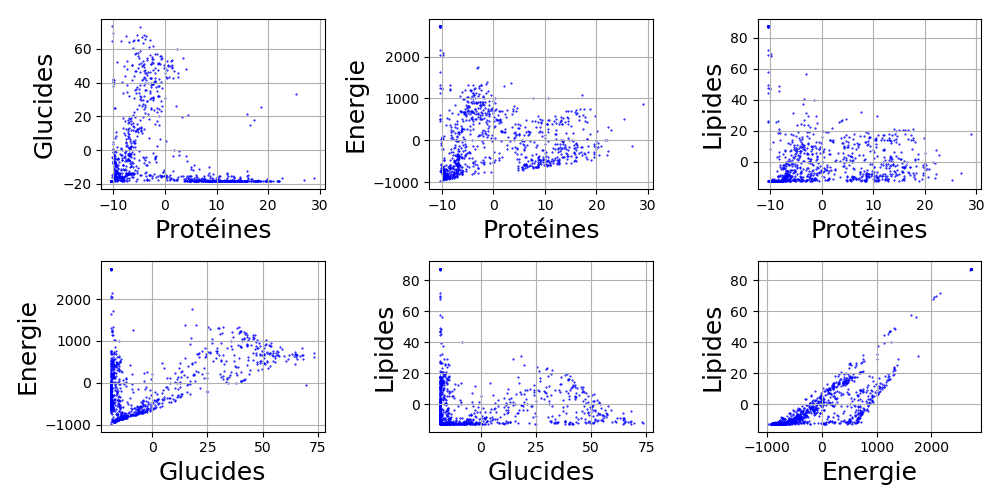

In [11]:
plot_croises(Xc)

Il apparait d'autre part qu'on se trouve un peu embarrassé avec ces qualificatifs de fort ou faible car les différents paramètres ne couvrent pas des échelles semblables. Il est donc utile de normaliser les données, c'est à dire non seulement de centrer les données  mais aussi de diviser par l'écart type de chaque caractère toutes les données relatives à ce caractère.
La covariance entre deux variables aléatoires normalisées porte alors le nom de corrélation entre ces variables. 

On définit donc la corrélation entre deux variables aléatoires X et Y par:

$$\rho(X,Y)=E(\frac{X-E(X)}{\sigma_{X}}\frac{Y-E(Y)}{\sigma_{Y}}).$$

Ce coefficient est compris entre -1 et 1. Lorsqu'il est proche de 1 en valeur absolue les variables X et Y sont très corrélées (positivement ou négativement). On a la propriété évidente : $\rho(X,X)=1.$

Pour un vecteur aléatoire la matrice de covariance sur les variables (composantes de ce vecteur) normalisées est alors appelée matrice de corrélation et sera notée $\mathbf{R}$. La corrélation entre deux paramètres $X_i$ et $X_j$ du vecteur $\mathbf{X}$ sera alors le terme en ième ligne jème colonne de cette matrice. La diagonale de cette matrice ne comportera que des 1.

In [12]:
Xn=Xc/np.std(X,0)# ce serait impensable en matlab (et violemment interdit sur une copie d'algèbre) 
#mais ici python devine quelles sont les dimensions adéquates ...
R_est=np.dot(Xn.T,Xn)/(N-1)
print(features_names)
print("Matrice d'autocorrélation \n", R_est)

# ou bien
R=np.corrcoef(X.T)
print(features_names)
print("Matrice d'autocorrélation issue de la fonction corrcoef Python\n", R)

['Protéines', 'Glucides', 'Energie', 'Lipides']
Matrice d'autocorrélation 
 [[ 1.00 -0.32  0.01 -0.01]
 [-0.32  1.00  0.41 -0.11]
 [ 0.01  0.41  1.00  0.84]
 [-0.01 -0.11  0.84  1.00]]
['Protéines', 'Glucides', 'Energie', 'Lipides']
Matrice d'autocorrélation issue de la fonction corrcoef Python
 [[ 1.00 -0.31  0.01 -0.01]
 [-0.31  1.00  0.41 -0.11]
 [ 0.01  0.41  1.00  0.84]
 [-0.01 -0.11  0.84  1.00]]


D'après cette matrice de corrélation:

- Les quantités de glucides et lipides ne sont pas corrélées (ça ne veut pas dire que le nuage est uniforme autour de 0)
- Les quantités de protéines et lipides sont peu corrélées  de même que protéines et glucides.
- La quantité de lipides et la valeur énergétique sont très corrélées
- La quantité de glucides et la valeur énergétique sont assez corrélées.

Ces coefficients de covariance ou corrélation sont très utiles et efficace pour "mesurer" un lien de type linéaire entre deux paramètres, c'est à dire quand le nuage de points est réparti autour d'une droite.  En revanche si les nuages forment d'autres formes complexes caractérisant un lien non linéaire, ils sont tout à fait inefficaces. Illustrons par des exemples de simulation.

Créons un lien linéaire entre deux variables aléatoires (à un bruit additif près).

<IPython.core.display.Javascript object>


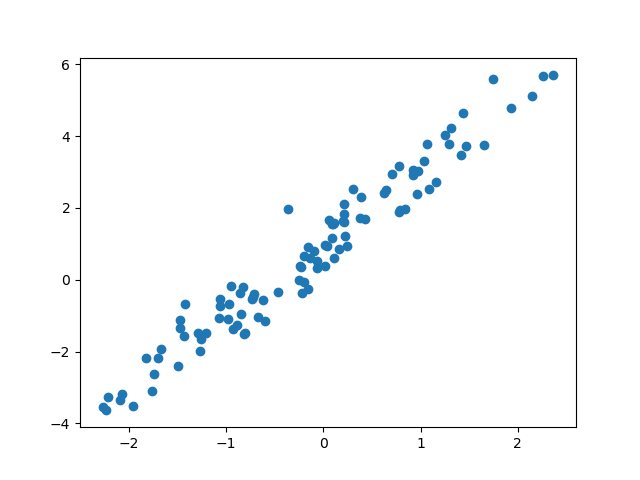

In [13]:
plt.figure()
x=np.sort(np.random.normal(0,1,(100,)))
eps=0.5
yl=2*x+1 + eps*np.random.normal(0,1,(100,))
plt.scatter(x,yl)

Le coefficient de corrélation vaut ?

In [14]:
print('{:.2f}'.format(np.corrcoef(x,yl)[0,1]))

0.97


En revanche si le lien est quadratique par exemple,

<IPython.core.display.Javascript object>


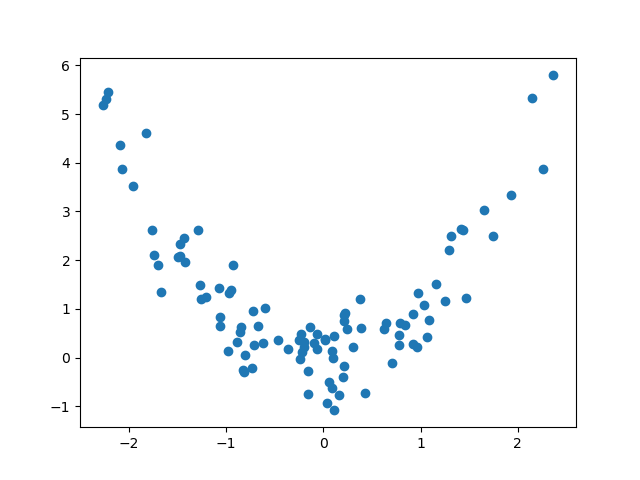

In [15]:
yq=x*x + eps*np.random.normal(0,1,(100,))
plt.figure()
plt.scatter(x,yq)

In [16]:
print('{:.2f}'.format(np.corrcoef(x,yq)[0,1]))

-0.13


En revanche il y a bien sûr une corrélation importante entre y et $x^2$

In [17]:
print('{:.2f}'.format(np.corrcoef(x*x,yq)[0,1]))

0.93


## Régression

La régression en général consiste à prédire une variable de sortie "quantitative" dite dépendante $Y$ à partir de la connaissance des valeurs d’un jeu de variables dites indépendantes $X=(X_1,X_2,...,X_p)$, c’est-à-dire pour $X = x$. 

En d’autres termes on suppose qu'il existe un modèle de la forme : $$Y = f(X) + \varepsilon$$ où $\varepsilon$ représente l'erreur et l'incertitude du modèle.

On cherche alors à estimer  : $$\hat{y}=f(x)$$ pour $X=x$ (le signe ^ indique qu’il s’agit d’une estimation).

Exemple: prédire $Y=X_3$ (valeur énergétique) à partir des autres composantes $X=(X_1,X_2,X_4)$

Ce problème est supervisé au sens où on dispose d’une base d’apprentissage qui est un ensemble de couples   ${(x_i,y_i) ; i=1:N}$. La connaissance des vraies valeurs $y_i$ pour cette base va permettre de construire la fonction f.

Il existe plusieurs approches pour effectuer cette prédiction:
- l'approche théorique (fonction de régression)
- la régression linéaire 
- la méthode des k plus proches voisins

### Approche théorique: 
    

La fonction $f(x)$ est celle qui minimise le critère MSE (Mean Squared Error ou Erreur quadratique moyenne): 
$$J(f)=\mathbb{E}((Y-f(X))^2)$$
qui s'écrit encore:
$$ J(f)=\mathbb{E}_{X}(\mathbb{E}_{Y|X}((Y-f(X))^2|X) $$

Pour chaque point x  la valeur f(x) optimale est donc : 
$$f(x)=\underset{c}{arg\,min}(\mathbb{E}_{Y|X}((Y-c)^2|X=x),$$
dont la solution s'écrit : 
$$\hat{y} = f(x) = \mathbb{E}_{Y|X}(Y|X=x).$$

Cette fonction s'appelle la **fonction de régression**.

*Remarque*: Cette fonction indique aussi que si on ne connait pas la valeur de X, la meilleure prédiction possible de Y est $\mathbb{E}(Y)$. Cette prédiction est la prédiction basique (baseline) qui sert de référence pour les critères de performances de la régression.

#### Illustration:

<IPython.core.display.Javascript object>


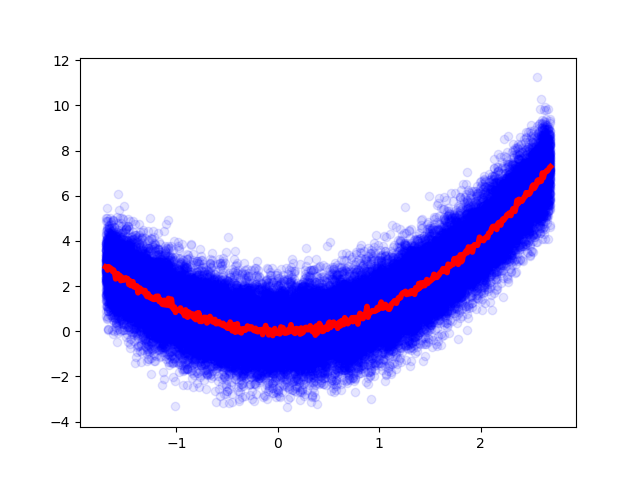

In [18]:
plt.figure()
xr=np.arange(-1.7,2.7,0.01)

y=xr**2 + np.random.normal(0,1,(100,len(xr)))

for i in range(100):
    plt.scatter(xr,y[i,:],c='b',alpha=0.1)

y_est=np.mean(y,0)

plt.plot(xr,y_est,color='r',linewidth=4)

#### Problèmes:
- On cherche y pour des valeurs de x possiblement différentes de celles rencontrées dans la base d’apprentissage
- On ne connait pas théoriquement la loi conditionnelle $Pr(Y|X=x)$

### Modèles de régression


Cette méthode de régression suppose que la relation entre la sortie $Y$ et les variables explicatives $X=(X_1,X_2,...,X_p)$ peut être décrite par un modèle paramétrique (fonction paramétrique):
$$ Y = f_\mu(X) + \varepsilon $$
avec $f_\mu(\cdot)$ la fonction paramétrable, $\mu = (\mu_1,\mu_2,\cdots,\mu_k)$ les paramètres et $\varepsilon$ est un terme de bruit additif indépendant de X.

Pour cette approche, il faut choisir la famille de fonction paramétrique (linéaire, polynomiale, exponentielle, ...), ce choix doit être effectué de manière justicieux apres l'analyse des varables explicatives et de la sortie afin de ne pas avoir de problème de sur-apprentissage ou sous-apprentissage.

Une fois le modèle paramétrique choisit, il faut **apprendre le modèle** c'est à dire **déterminer les paramètres $\mu_i$** de la fonction $f_\mu(\cdot)$.

Pour ce faire la technique la plus communément utilisée consiste à rechercher les paramètres $\mu_i$ telque le **critère des moindres carrés (MC) (least squares (LS))** entre la sortie réèlle $Y$ et la sortie prédite $\hat{Y} = f_\mu(X)$ soit **minimal en moyenne** sur la base d'apprentissage:
$$J(f_\mu)=\mathbb{E}((Y-f_\mu(X))^2).$$
La valeur des paramètres $\mu_i$ qui minimise le mieux (optimum) le le critère MSE $J(f_\mu)$ est noté :
$$\mu^* = \underset{\mu}{arg\,min} \mathbb{E}((Y-f_\mu(X))^2).$$

Une fois $\mu^*$ obtenu, il est possible d'estimer la sortie $\hat{Y}$ en évaluant $f_{\mu^*}(X)$ pour n'importe quelle valeur $X$.

Il s'agit donc d'une méthode d'apprentissage supervisé dans la mesure où il est nécessaire de connaitre la "vraie" sortie sur une base d'apprentissage pour déterminer les coefficients qui permettront de prédire la valeur de sortie de données d'entrée n'appartenant pas à cette base. 

#### Problèmes:
Dans la majorité des cas, obtenir l'ensemble des parametres optimaux $\mu^*$ n'est pas un problème trivial car souvent il n'existe pas de formule analytique. Il faut faire appel à des méthodes itératives, telque la descente de gradient, pour obtenir une approximation de $\mu^*$.

### Cas du modèle de régression linéaire

Dans ce cas, nous supposont que la fonction $f_\mu(X)$ est une fonction linéaire :
$$Y = \sum_{i=1}^{p}b_i X_i + b_0 + \varepsilon$$
où $\varepsilon$ est un terme de bruit additif indépendant de X et de moyenne nulle et $\mu=(b_0,b_1,\cdots,b_i,\cdots,b_p)$ les paramètres du modèle.

L'ensemble d'apprentissage est constinué de $N$ couple :
$$\{(y_n,x_n=(x_{n,1},...,x_{n,p}))\}_{n\in[1,\cdots,N]},$$
avec $y_n$ la valeur de sortie associée aux variables explicatives $x_n=(x_{n,1},...,x_{n,p})$.

Le critère MSE, s'écrit alors : 
$$\sum_{n=1}^{N}\left ( y_n - \hat{y}_n \right )^{2}$$
avec $\hat{y}_n =\sum_{i=1}^{p}b_i x_{n,i}  + b_0$. (Notons que le facteur multiplicatif de la moyenne $1/N$ n'est pas nécessaire car il est indépendant des paramètres d'apprentissages.)

La technique de régression linéaire est souvent dénommée **OLS** pour Ordinary Least Squares dans la littérature. 

Nous allons tout d'abord développer le cas le plus simple où l'on considère un seul paramètre d'entrée (**régression linéaire simple (RSS)**), puis généraliserons (sans développer les calculs) au cas multi-dimensionnel. 

### Régression linéaire simple

Si nous prenons le cas le plus simple de regressions linéaire de $\mathbb{R} \to \mathbb{R}$, le modèle linaire se réduit alors à : $$Y = b_1 X + b_0 + \varepsilon,$$
avec $b_0$ l'intercept (valeur d'interception avec l'axe des ordonnées $\mathcal{o}_Y$) et $b_1$ la pente (valeur de l'accroissement de la sortie pour un accroissement unitaire de l'entrée). 

Les coefficients $b_0$ et $b_1$ sont ceux qui minimisent le critère des moindres carrés suivant: $$J(b_0,b_1)=\sum_{n=1}^{N} (y_n -\hat{y}_n)^2 =  \sum_{n=1}^{N} (y_n - (b_1 x_n + b_0))^2.$$ 
Remarquons que ce critère est quadratique en fonction des coefficients $b_0$ et $b_1$. 

<IPython.core.display.Javascript object>


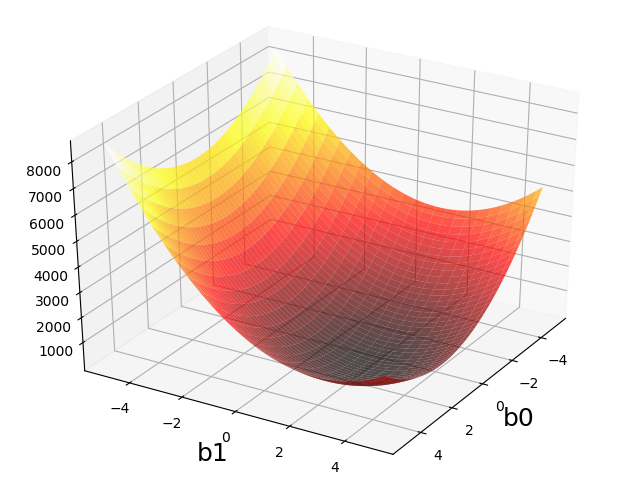

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
# création d'une grille 2D de b0 et b1 possibles
b0g = np.linspace(-5,5,50)
b1g = np.linspace(-5,5,50)
bm0,bm1 = np.meshgrid(b0g, b1g)
rss=0
for n in range(x.shape[0]):
    resm_n=yl[n]-(bm1*x[n]+bm0)#calcul d'un résidu
    rss=rss+resm_n**2#calcul du RSS
    
ax.plot_surface(bm0,bm1, rss, rstride=2, cstride=1, cmap=plt.cm.hot,linewidth=1, alpha=0.7,antialiased=True)
ax.set_xlabel('b0',fontsize=18)
ax.set_ylabel('b1',fontsize=18)


#### Recherche du minimum:

Pour trouver les valeurs de $b_0$ et de $b_1$ telque le critère soit minimum, nous utilisons une propriété fondamentale en analyse fonctionnelle : Quand l'ensemble des dérivées partielles d'une fonction par rapport à ces paramètre s'annulent alors nous somme dans un minima ou un maxima ou un point selle.

Dans le cas de fonction quadratique, il y a uniquement un seul minima et il n'y a pas de point maxima et de point selle. Les dérivées partielles de notre critère sont :
$$\frac{\partial J}{\partial b_0} = 2\sum_{n=1}^{N}(y_n-(b_1 x_n-b_0))$$
et
$$\frac{\partial J}{\partial b_1} = -2\sum_{n=1}^{N}(y_n-(b_1 x_n-b_0))x_n.$$

L'optimum est alors obtenu en résolvant le systeme d'équation suivant : $\frac{\partial J}{\partial b_0}(b_0,b_1)=0$ et $\frac{\partial J}{\partial b_1}(b_0,b_1)=0$. Nous obtenons alors :

- $b_0 = \overline{y}-b_1\overline{x}$, avec $\overline{y} = \frac{1}{N}\sum_{n=1}^{N}y_n$ et $\overline{x} = \frac{1}{N}\sum_{n=1}^{N}x_n$

- $b_1=\frac{\sum_{n=1}^{N} (y_n -\bar{y})(x_n-\bar{x})}{\sum_{n=1}^{N} (x_n-\bar{x})^{2}}.$

Ce coefficient dépend donc du rapport de l'estimée de la covariance entre x et y à l'estimée de la variance de x:  $$b_1=\hat{cov}(X,Y)/\hat{\sigma}_X^2.$$

In [20]:
#programme "maison" pour avoir b0 et b1
import numpy as np

def reg_simple(x,y):
    matcov=np.cov(x,y)
    b1=matcov[0][1]/matcov[0][0]
    b0=np.mean(yl)-b1*np.mean(x)

    print('Pente : b1 = %.2f'%b1)
    print('Intercept : b0 =%.2f '%b0)
    return b0,b1


In [21]:
b0,b1=reg_simple(x,yl)

Pente : b1 = 2.01
Intercept : b0 =0.99 


#### Tracé de la droite de régression dans le nuage de points (x,y)

<IPython.core.display.Javascript object>


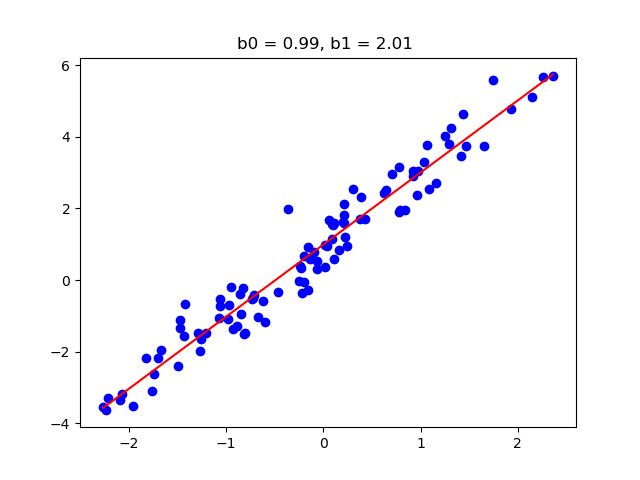

In [22]:
plt.figure()
plt.scatter(x,yl,c='b')
xi = np.linspace(min(x), max(x),20)
yi=b0+b1*xi
plt.plot(xi,yi,c='r')
plt.title('b0 = %.2f, b1 = %.2f '%(b0,b1))

#### Performances de cette régression - RSS

Sur l'exemple ci dessus cela semble plutot pas mal, car on retrouve à peu près les coefficients du "vrai" modèle à l'origine des données.
En général on ne dispose évidemment pas de ce vrai modèle et la performance peut être mesurée par le critère sur lequel s'est fondé l'optimisation après avoir effectué celle ci, c'est le critère RSS (acronyme de Residual Square Sum, somme des résidus aux carrés), le résidu étant la part non prédictible de $Y$ c'est à dire $Y - \hat{Y}$. $$RSS =\sum_{n=1}^{N} (y_n -\hat{y}_n)^2$$.

Nous pouvons déterminer théoriquement le critère RSS **sur la base qui a servi à l'apprentissage**. Dans ce cas : $$RSS_{app} =\sum_{n=1}^{N} (y_n -\bar{y})^2 -b_1\sum_{n=1}^{N} (x_n-\bar{x})(y_n -\bar{y}) $$
qui peut encore s'écrire en intégrant l'expression de $b_1$ :
$$RSS_{app} =(N-1)\hat{\sigma}_Y^2 - (N-1)\hat{cov}(X,Y)^2/\hat{\sigma}_X^2$$ 
ou bien encore:
$$RSS_{app} =(N-1)\hat{\sigma_Y}^2(1 - \hat{\rho}(X,Y)^2).$$ 

Ce critère RSS dépend donc de l'estimée de la corrélation entre X et Y, $\hat{\rho}(X,Y)$ : plus cette corrélation est importante (proche de 1 en valeur absolue) plus le RSS est faible.

Il dépend aussi de la variance estimée de la variable dépendante Y: plus cette variance est importante plus le RSS est important.

In [23]:
matcov=np.cov(x,yl)
RSS=(N-1)*(matcov[1][1]-matcov[0][1]**2/matcov[0][0])
print('RSS = %.2f'%RSS)

RSS = 244.72


Le problème avec ce critère est qu'il dépend de l'étendue des données de sortie et qu'il n'est pas simple d'apprécier la qualité de la régression.

#### Autres critères de mesure de la performance de la régression : RSE et $R^2$ score

Il n'est pas très facile d'interpréter le critère RSS et il est utile de mesurer la performance de la régression par deux autres critères. 

- RSE:

C'est l'écart type du résidu (Residual Standard Error ) qui peut facilement être estimé à partir du critère RSS: $RSE=\sqrt{\frac{RSS}{N-2}}$. RSE représente l'écart moyen entre la droite de régression et la vraie réponse. Il mesure donc un manque d'ajustement de cette droite aux données. Ce critère est plus parlant que le RSS mais reste tout de même dépendant de l'étendue de Y et sa valeur n'a de sens que comparée à l'écart type de Y. 

- $R^2$ score:

Pour obtenir un critère "normalisé" qui permette à lui seul d'évaluer la qualité de la régression on définit le $R^2$ score ou $R^2$ statistique de la façon suivante: $R^2 = (TSS - RSS)/TSS$  où  $TSS =\sum_{n=1}^{N} (y_n -\bar{y})^2$.

Rappelons que  $TSS =\sum_{n=1}^{N} (y_n -\bar{y})^2$ mesure, au facteur (N-1) près la variance de Y et peut être vue comme la part de variabilité inhérente à cette variable avant que la régression n'ait eu lieu. TSS représente aussi le critère RSS obtenu pour la prédiction "baseline" :$\hat{y}_n =\bar{y}$ 

Par contraste RSS mesure la part de variabilité qui reste inexpliquée après que la régression a été effectuée. 

Par conséquent TSS−RSS mesure la part de variabilité de Y qui est expliquée et enlevée par la régression et $R^2$ mesure donc la proportion de cette variabilité de Y qui peut être expliquée et absorbée en utilisant X.

#### Illustration

In [24]:
y=yl
#y=yq
xl = x
#x=xl**2
b0,b1=reg_simple(x,y)


Pente : b1 = 2.01
Intercept : b0 =0.99 


<IPython.core.display.Javascript object>


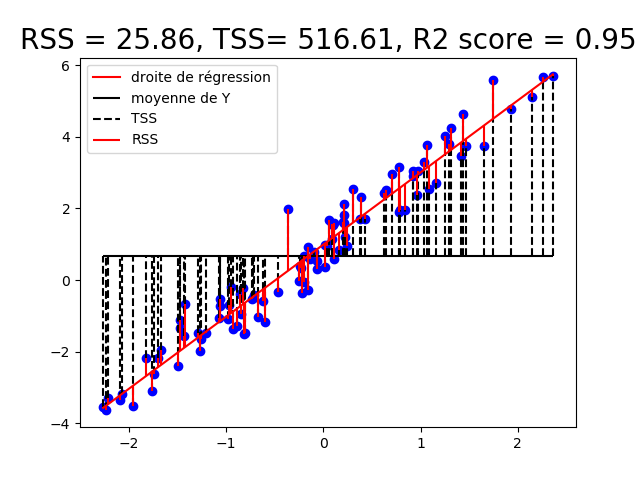

In [25]:
plt.figure()
plt.scatter(x,y,c='b')
xi = np.linspace(min(x), max(x),20)
yi=b0+b1*xi
m=np.mean(y)
s=np.std(y)
ypred=b0+b1*x
plt.plot(xi,yi,c='r',label='droite de régression')
plt.hlines(m,min(x),max(x),label='moyenne de Y')
plt.vlines(x,np.minimum(y,m),np.maximum(y,m),linestyles='dashed', label='TSS', )
plt.vlines(x,np.minimum(y,ypred),np.maximum(y,ypred),color='red',label='RSS')

plt.legend()

RSS=sum((y-ypred)**2)
TSS=sum((y-m)**2)
R2=(TSS-RSS)/TSS
plt.title('RSS = %.2f, TSS= %.2f, R2 score = %.2f'%(RSS,TSS,R2),fontsize=20)

Dans le cas d'une régression linéaire simple et **sur la base d'apprentissage** , on montre de façon immédiate que: $$R^2=\hat{\rho}(X,Y)^2.$$
Rappelons que ce coefficient est compris entre -1 et 1. S'il est proche de 1 en valeur absolue, ce qui signifie que X et Y sont très corrélés (positivement ou négativement) la régression linéaire est efficace.


D'après ce qui précède la régression linéaire ne doit pas être très adaptée ni efficace dans le cas où Y ne dépend pas linéairement de X.

On peut reprendre les instructions précédentes pour faire une régression linéaire dans le cas où y=yq.

On peut enfin reprendre ces instructions en remplaçant x par $x^2$ et avec y=yq.

In [26]:
#le faire en reprenant les 2 cellules de code précédentes

#### Mise en oeuvre avec Scikit learn

Le module **scikit learn** fournit la classe **linear_model.LinearRegression()** qui permet la mise en oeuvre de cette régression linéaire, avec le calcul des meilleurs coefficients de régression et du $R^2$ score. 
Comme pour d'autres classes de sklearn déja utilisées pour d'autres applications c'est la méthode **fit** qui permet d'ajuster le modèle. La méthode **score** permet de mesurer le $R^2$ score.
La méthode **predict** permet de générer les prédictions $\hat{y}$ à partir d'entrées x.

Le code ci dessous met en oeuvre cette technique et trace la droite obtenue dans le nuage de points.

In [27]:
from sklearn import linear_model    
regr = linear_model.LinearRegression()# instance d'une classe de régression linéaire

In [28]:
def regression_simple(x,y): 
    #calcul du modèle
    regr.fit(x,y)
    # The coefficients
    b0=regr.intercept_
    b1=regr.coef_[0]
    # Le score R2
    R2=regr.score(x, y)
    plt.figure()
    plt.scatter(x,y,c='b')
    #les valeurs prédites 
    ypred=regr.predict(x)
    plt.plot(x,ypred,c='r')
    plt.title('b0 = %.2f, b1 = %.2f, R2 = %.2f'%(b0,b1,R2),fontsize=20)
    #return b0,b1,R2

<IPython.core.display.Javascript object>


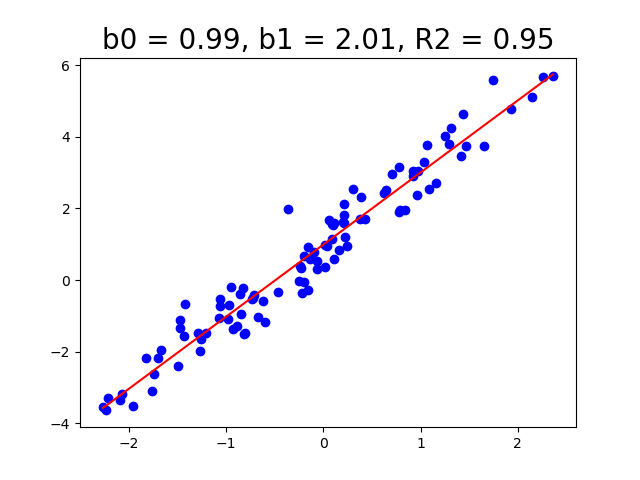

In [29]:
x=x.reshape((len(x),1))
regression_simple(x,yl)

### Retour aux données de composition des aliments

Le point important qui explique cette souplesse d'emploi de la régression linéaire est que la **linéarité** est **par rapport aux coefficients de prédiction**, ce qui est indispensable pour que la solution soit obtenue en annulant la dérivée du critère par rapport aux coefficients.

D'après la matrice de corrélation de ces données il semble judicieux d'essayer de prédire la valeur énergétique des aliments à partir de leur teneur en lipides. 

<IPython.core.display.Javascript object>


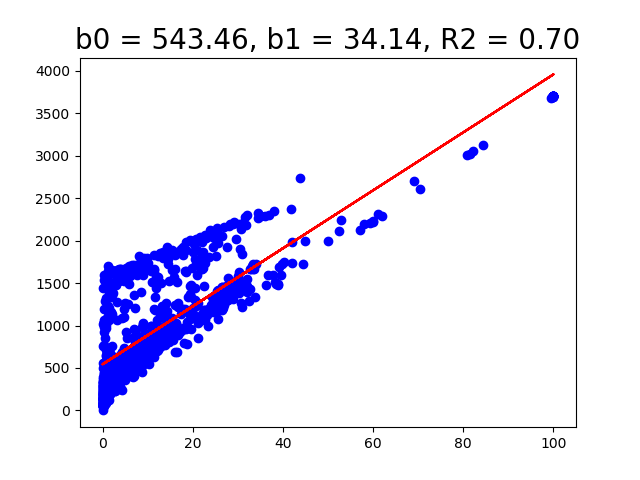

In [30]:
x=X[:,[3]]#la quantité de lipides
y=X[:,2]#la valeur énergétique
regression_simple(x,y)

** Interprétation **
- Le score R2 est assez bon (c'est lié à la corrélation entre les variables quantité de lipides et valeur énergétique).
- Lorsque la quantité de lipides dans un aliment s'accroit de 1g (pour 100g)  la valeur énergétique s'accroit (en moyenne)de b1 kcal (pour 100g)

<IPython.core.display.Javascript object>


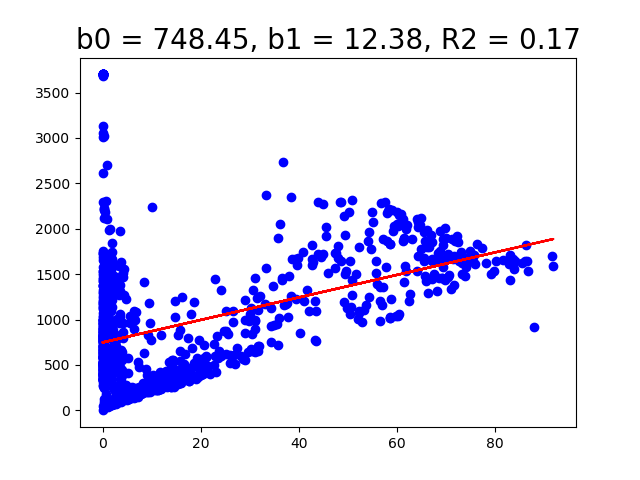

In [31]:
x=X[:,[1]]#la quantité de glucides
y=X[:,2]#la valeur énergétique
regression_simple(x,y)

** Interprétation **
- Le score R2 est assez mauvais (c'est lié à la faible corrélation entre les variables quantité de glucides et valeur énergétique).
- Lorsque la quantité de glucides dans un aliment s'accroit de 1g (pour 100g)  la valeur énergétique s'accroit (en moyenne)de b1 kcal (pour 100g)

#### Validation sur une base de test

Pour avoir des performances qui ne soient pas seulement celles obtenues sur la base ayant servi à l'apprentissage il convient de scindre la base disponible en deux parties, une pour l'apprentissage et l'autre pour le test. La fonction train_test_split du module cross_validation de sklearn permet d'opérer cette séparation (par défaut on garde 75% des données pour l'apprentissage et 25% pour le test).

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X)

Faisons l'essai pour Energie % lipides

In [33]:
N,p=np.shape(X_train)
regr.fit(X_train[:,[3]],X_train[:,2])
# The coefficients
b1=regr.coef_[0]
b0=regr.intercept_
RSS=np.linalg.norm(X_train[:,2] - regr.predict(X_train[:,[3]])) ** 2
RSE=np.sqrt(RSS/(N-2))
R2_train=regr.score(X_train[:,[3]],X_train[:,2])
R2_test=regr.score(X_test[:,[3]],X_test[:,2])
print('R2 score training = %.2f, R2 score test = %.2f'%(R2_train,R2_test))

R2 score training = 0.69, R2 score test = 0.72


Parfois des résultats curieux mais explicables...

Idem pour Energie % glucides

In [34]:
regr.fit(X_train[:,[1]],X_train[:,2])
# The coefficients
b1=regr.coef_[0]
b0=regr.intercept_
RSS=np.linalg.norm(X_train[:,2] - regr.predict(X_train[:,[1]])) ** 2
RSE=np.sqrt(RSS/(N-2))
R2_train=regr.score(X_train[:,[1]],X_train[:,2])
R2_test=regr.score(X_test[:,[1]],X_test[:,2])
print('R2 score training = %.2f, R2 score test =%.2f'%(R2_train,R2_test))

R2 score training = 0.17, R2 score test =0.16


On peut se demander s'il ne serait pas possible de prédire assez efficacement la valeur énergétique à partir des 2 paramètres d'entrée glucides et lipides. Ce sera de la régression linéaire multiple.

### Regression linéaire multiple

Nous n'allons pas re-développer la théorie, à savoir l'obtention des coefficients de la régression et le calcul des performances théoriques sur la base d'apprentissage.
Rappelons simplement les points suivants:

 - Le modèle sous jacent est :$$Y = \sum_{i=1}^{p}b_i X_i + b_0 + \varepsilon$$
 - On interprète $b_i$ comme l'effet moyen sur Y d'un accroissement unitaire de $X_i$ , toutes les autres variables $X_j$ étant fixées.
 - La sortie Y est prédite pour une entrée $X=x$ suivant : $\hat{y}=\sum_{i=1}^{p}b_i x_i + b_0$. 
 - Les coefficients $b_i$ sont ceux qui minimisent le critère LS $\sum_{n=1}^{N} (y_n -\hat{y}_n)^2$ , la somme étant effectuée sur les données $(y_n,(x_{n,1},...,x_{n,p}))$ de **la base d'apprentissage**.
 - Les coefficients $b_i$ sont solution du système linéaire obtenu en annulant la dérivée du critère par rapport à ces coefficients.
 - Pour mesurer les performances de la prédiction il faut calculer le $R^2$ score pour la base d'apprentissage et ** pour une base de test**.


C'est toujours l'outil de sklearn linear_model.LinearRegression() qui est utilisé en pratique.
Mettons le en oeuvre sur les données d'aliments pour essayer de prédire la valeur énergétique à partir des 2 paramètres d'entrée glucides et lipides. 

In [35]:
regr.fit(X_train[:,[1,3]],X_train[:,2])
# The coefficients
b1=regr.coef_[0]
b2=regr.coef_[1]
b0=regr.intercept_
R2_train=regr.score(X_train[:,[1,3]],X_train[:,2])
R2_test=regr.score(X_test[:,[1,3]],X_test[:,2])
print('R2 score training = %.2f, R2 score test =%.2f'%(R2_train,R2_test))

R2 score training = 0.96, R2 score test =0.97



Une petite représentation graphique s'impose.

<IPython.core.display.Javascript object>


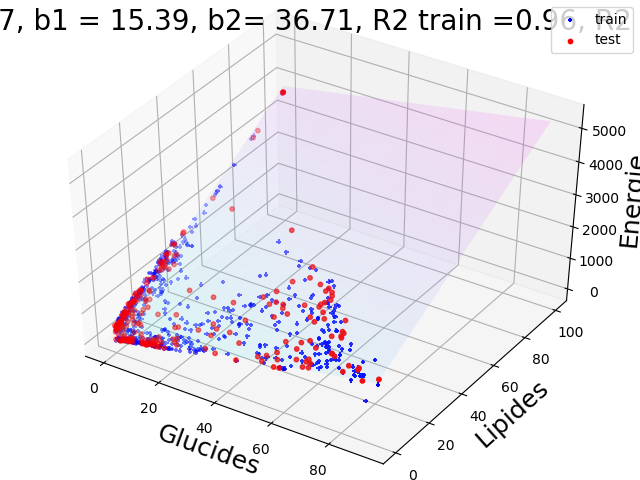

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_train[:,1],X_train[:,3],X_train[:,2], zdir='z',marker='+', s=10, c='b',label='train')
ax.scatter(X_test[:,1],X_test[:,3],X_test[:,2], zdir='z', marker='o',s=10, c='r',label='test')
ax.legend()
# création d'une grille 2D
xi = np.linspace(min(X[:,1]), max(X[:,1]),20)
yi = np.linspace(min(X[:,3]), max(X[:,3]),20)
xmi,ymi = np.meshgrid(xi, yi)
# interpolation
zmi=b1*xmi+b2*ymi+b0
ax.plot_surface(xmi,ymi, zmi, rstride=1, cstride=1, cmap=plt.cm.cool,linewidth=1, alpha=0.1,antialiased=True)
ax.set_xlabel(features_names[1],fontsize=18)
ax.set_ylabel(features_names[3],fontsize=18)
ax.set_zlabel(features_names[2],fontsize=18)
ax.set_title('b0 = %.2f, b1 = %.2f, b2= %.2f, R2 train =%.2f, R2 test = %.2f'%(b0,b1,b2,R2_train,R2_test),fontsize=20)

**Interprétation**
- Lorsque la quantité de glucides dans un aliment s'accroit de 1g (pour 100g) (la quantité de lipides restant fixe) la valeur énergétique s'accroit en moyenne de b1 kcal (pour 100g)
- Lorsque la quantité de lipides dans un aliment s'accroit de 1g (pour 100g) (la quantité de glucides restant fixe) la valeur énergétique s'accroit en moyenne de b2 kcal (pour 100g)

### Cas de la régression non-linéaire

La regression non-linéaire est le cas général des problèmes de régressions, les cas linéaires sont malheureusement tres rare et mettre en oeuvre une régression non-linéaire est généralement plus complexe.

Il existe cependant une famille de modèle non-linéaire tres facile à mettre en oeuvre car elle peut être ramené à une régression linéaire.
Cette famille est l'ensemble des fonctions paramétrées composées d'une combinaison linéaire de fonctions non-linéaires et non-paramétrées :
$$ Y = \sum_{i=1}^D \mu_i g_i(X),$$
avec $g_i(\cdot)$ des fonctions non-linéaires et $\mu_i$ les coefficients de la combinaison linéaire.

Nous voyons qu'il est alors tres symples avec ce type de fonction à se ramener à une régression linéaire multiple, cela revient à créer de nouvelles variables explicatives de la manière suivante :
$$ Y = \sum_{i=1}^D \mu_i g_i(X) =  \sum_{i=1}^D \mu_i X'_i,$$
avec $X'_i = g_i(X)$.

#### Régression polynomial

Avec cette méthode, nous pouvons étendre la régression linéaire à la régression polynomial, dans le cas de la régression polynomial simple ($\mathbb{R} \to \mathbb{R}$), nous avons la fonction paramétrés suivante :
$$y_n = \sum_{i=1}^D b_i x_n^i + b_0.$$

Que nous pouvons ramener à un probleme de régression linéaire multiple ($\mathbb{R}^D \to \mathbb{R}$) :
$$y_n = \sum_{i=1}^D b_i x'_{n,i} + b_0,$$
avec $x'_{n,i} = x_n^i$.

#### Mise en oeuvre avec Scikit learn

In [37]:
def regression_polynomial_simple(x,y,D):
    #création des nouvelles dimensions
    x_prim = np.hstack([x**(i+1) for i in range(D)])
    print(x_prim.shape, y.shape)
    #calcul du modèle
    regr.fit(x_prim,y)
    # The coefficients
    b0=regr.intercept_
    bi=regr.coef_
    # Le score R2
    R2=regr.score(x_prim, y)
    plt.figure()
    plt.scatter(x,y,c='b')
    #les valeurs prédites 
    ypred=regr.predict(x_prim)
    plt.plot(x,ypred,c='r')
    plt.title('b0 = %.2f, bi = %s, R2 = %.2f'%(b0,str(bi),R2),fontsize=20)
    #return b0,b1,R2

Nous pouvons tester avec les données yq:

(100, 2) (100,)


<IPython.core.display.Javascript object>


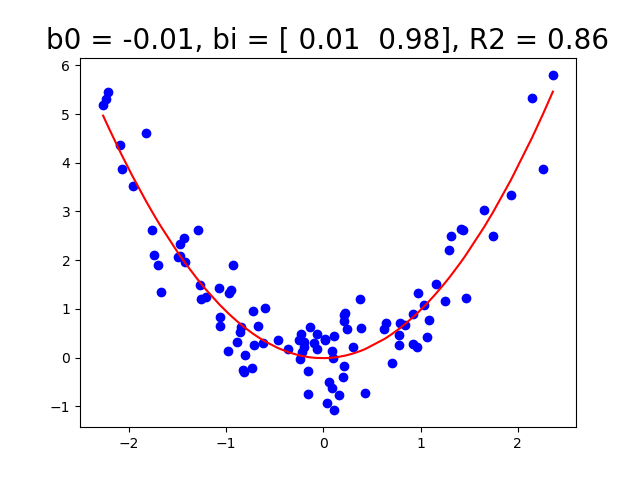

In [38]:
x=xl
x=x.reshape((len(x),1))
regression_polynomial_simple(x,yq,2)

Nous retrouvons bien la parabole d'équation $y = x^2$.

Et avec un polynome de beaucoup plus grand degré ?

(100, 41) (100,)


<IPython.core.display.Javascript object>


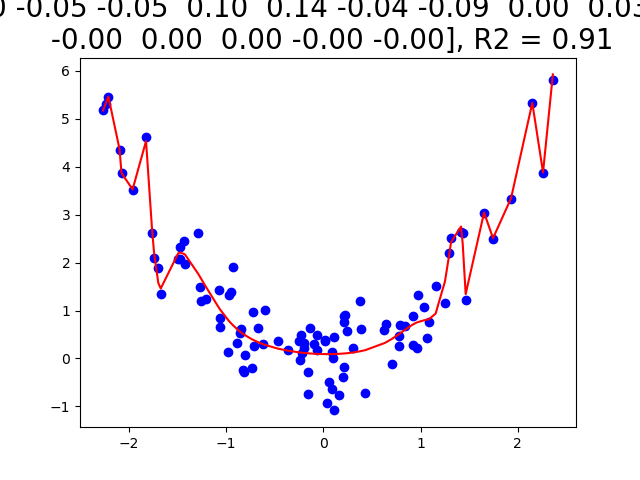

In [39]:
regression_polynomial_simple(x,yq,41)

Nous voyons un probleme problème de sur-apprentissage, le modèle est trop complexe.

### Méthode des K plus proches voisins

L’approche par PPV approxime la solution optimale théorique $\hat{y}=f(x) = E(Y|X=x)$ par : $$\hat{y} = Moy(y_n |    x_n \in Voisinage(x)).$$ 
Pour une valeur x d’entrée nouvelle, on détermine l’ensemble des K plus proches voisins de x dans la base d’apprentissage. La valeur prédite de la sortie ŷ est alors la moyenne des K valeurs y obtenues pour ces K plus proches voisins. 

Cette approche dépend évidemment du nombre K de plus proches voisins considérés
Elle dépend aussi fortement de la dimension des vecteurs de la base d’apprentissage et ses performances se dégradent notablement lorsque cette dimension augmente. En effet, même pour un nombre N important de données d’apprentissage, celles-ci ne couvrent pas tout l’espace $\mathbb{R}^p$ des données d’entrée à mesure que p croît.



#### Mise en oeuvre avec Scikit Learn (module neighbors)

In [40]:
from sklearn import neighbors

**Exemples de simulation (lien linéaire et quadratique entre Y et X)**
Pour ces exemples nous générerons une base d'apprentissage et une base de test car la technique du K=1 plus proche voisin a un R2 score de 1 (ou un RSS de 0) sur la base d'apprentissage. 

In [41]:
x=np.random.normal(0,1,(100,))
eps=0.5
yl=2*x+1 + eps*np.random.normal(0,1,(100,))
yq=x*x + eps*np.random.normal(0,1,(100,))
x=x.reshape((100,1))
xtest=np.random.normal(0,1,(100,))
yltest=2*xtest+1 + eps*np.random.normal(0,1,(100,))
yqtest=xtest*xtest + eps*np.random.normal(0,1,(100,))
xtest=xtest.reshape((100,1))

In [42]:
def reg_knn_1D(x,y,xtest,ytest):
    
    plt.figure()
    col=('b','g','r')
    i=0
    for k in (1,5,30):
        knn = neighbors.KNeighborsRegressor(k, weights='uniform')
        knn.fit(x,y)
        yppv=knn.predict(sorted(xtest))
        S=knn.score(xtest,ytest)
        plt.scatter(x,y,c='k')
        plt.plot(sorted(xtest), yppv, c=col[i],linewidth=2, label=('PPV K=%d, score= %.2f'%(k,S)))
        plt.legend(fontsize=15)
        i=i+1


<IPython.core.display.Javascript object>


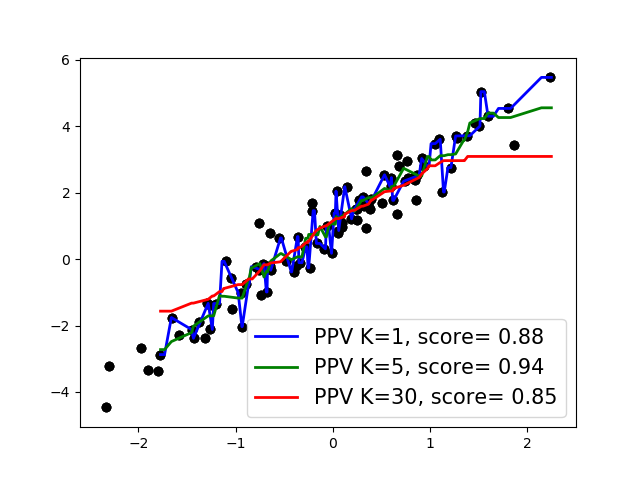

In [43]:
reg_knn_1D(x,yl,xtest,yltest)

<IPython.core.display.Javascript object>


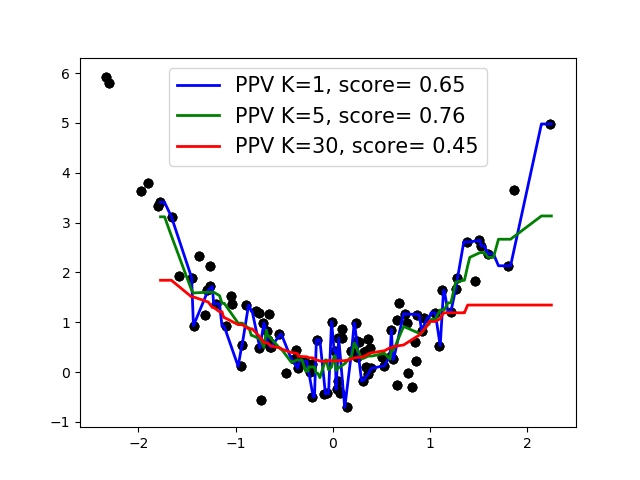

In [44]:
reg_knn_1D(x,yq,xtest,yqtest)

** Exemple de la base des aliments CIQUAL**

<IPython.core.display.Javascript object>


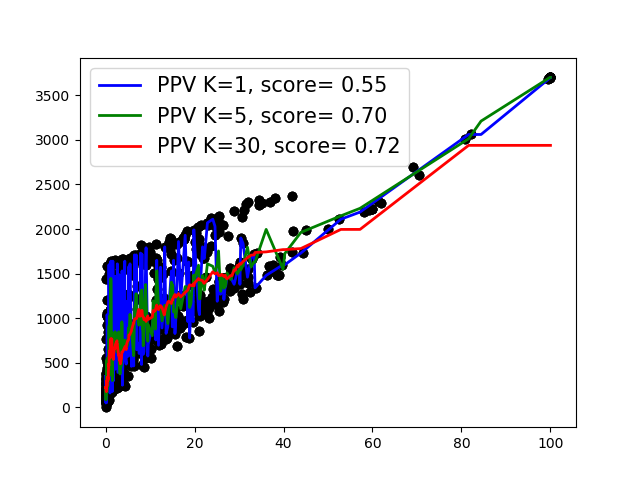

In [45]:
reg_knn_1D(X_train[:,[3]], X_train[:,2],X_test[:,[3]], X_test[:,2])

** Sur des données de dimensions 2** (lipides,glucides)

In [46]:

def reg_knn_2D(X,y,Xtest,ytest):
    for k in (1,5,30):
        knn = neighbors.KNeighborsRegressor(k, weights='uniform')
        knn.fit(X,y)
        S=knn.score(Xtest,ytest)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(X[:,0],X[:,1], y, zdir='z', s=20, c='b')
        # création d'une grille 2D
        xi = np.linspace(min(Xtest[:,0]), max(Xtest[:,0]),20)
        yi = np.linspace(min(Xtest[:,1]), max(Xtest[:,1]),20)
        xmi,ymi = np.meshgrid(xi, yi)

        zmi = knn.predict(np.c_[xmi.ravel(), ymi.ravel()])
        ax.plot_surface(xmi,ymi, zmi.reshape((20,20)), rstride=1, cstride=1, cmap=plt.cm.cool,linewidth=1, alpha=0.5,antialiased=True)
        
        ax.set_title('PPV K=%d, score= %.2f'%(k,S),fontsize=20)


<IPython.core.display.Javascript object>


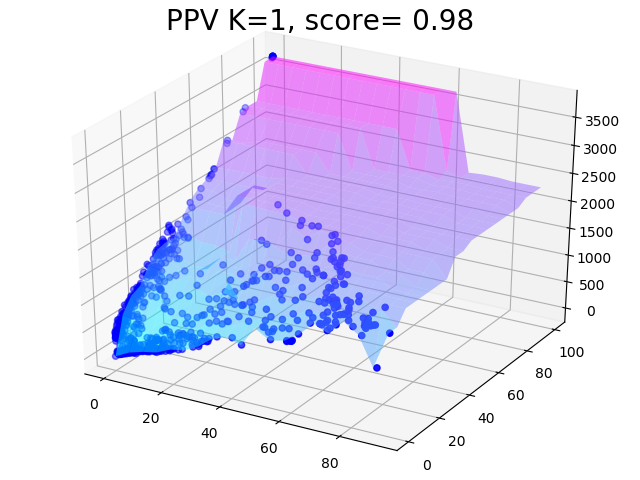

<IPython.core.display.Javascript object>


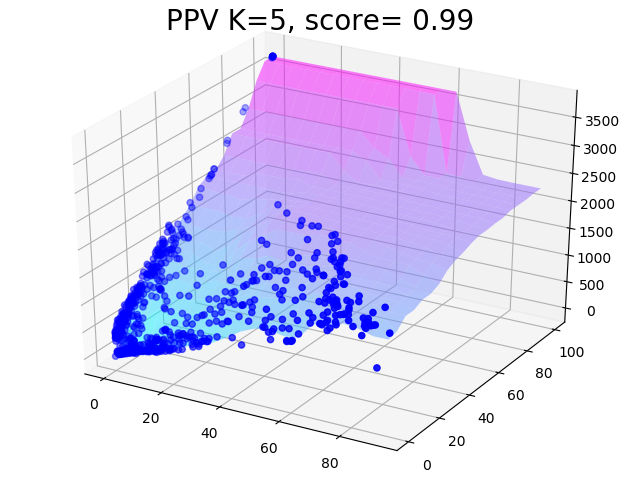

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


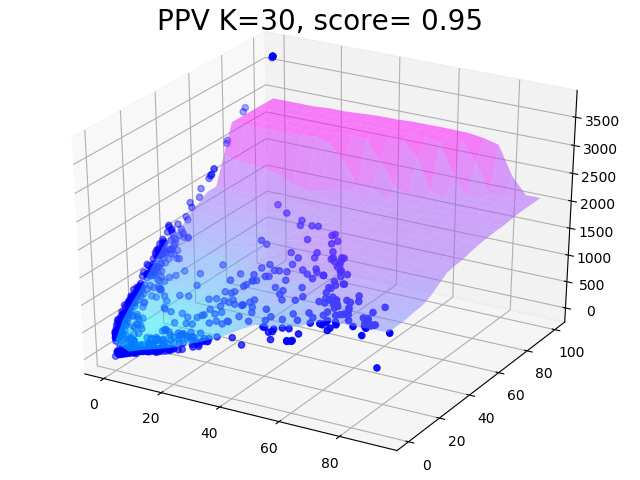

In [47]:
reg_knn_2D(X_train[:,[1,3]],X_train[:,2],X_test[:,[1,3]],X_test[:,2])

** Interprétation**
La courbe ou surface de régression est d'autant plus "lisse" que le nombre K de plus proches voisins considérés est important. La régression par plus proches voisins fonctionne bien quelque soit le type de lien entre les données (pas nécessairement de type linéaire).
En revanche cette technique n'est pas efficace lorsque la dimension p des variables indépendantes est importante (supérieure à 3).

#### Problème : à mesure que p augmente  les « voisins » s’éloignent 
Disposant de données uniformément réparties dans un hypercube unité de dim p, il faut pour capturer autour d’un point cible un hypercube contenant r(%) des données que cet hypercube ait une arête : $ e_p(r) = (\frac{r}{100})^{\frac{1}{p}}$.


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


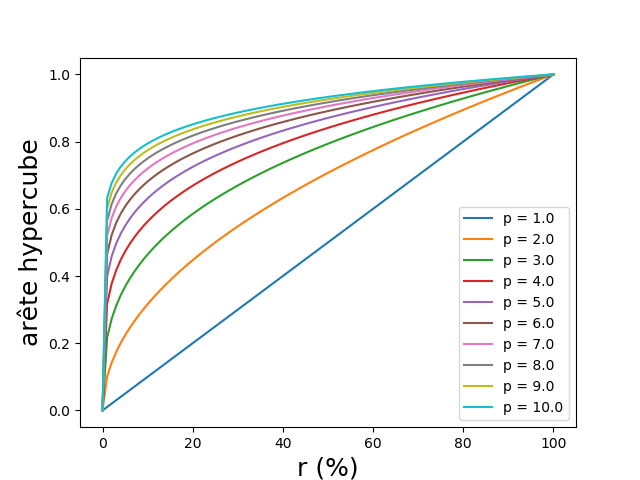

In [48]:
r=np.linspace(0,100,100)
plt.figure()
for p in np.arange(1,11):
    plt.plot(r,(r/100)**(1./p),label='p = %.1f'%p)
plt.xlabel('r (%)',fontsize=18)
plt.ylabel('arête hypercube',fontsize=18)
plt.legend()

Illustrons ceci en dimension 2.

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


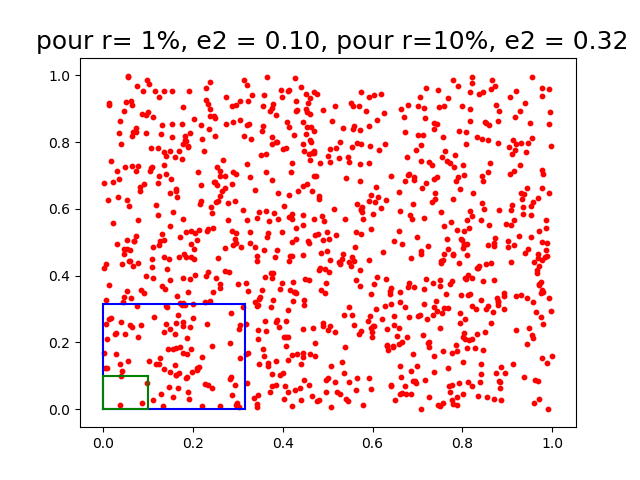

In [49]:
x=np.random.rand(1000)
y=np.random.rand(1000)
from itertools import product, combinations
plt.figure()
plt.scatter(x,y, s=10, c='r')
#draw cube
rmax_1sur10=0.1**(1./2)
r = [0, rmax_1sur10]
for s, e in combinations(np.array(list(product(r,r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        plt.plot(*zip(s,e), color="b")
rmax_1sur100=0.01**(1./2)
r = [0, rmax_1sur100]
for s, e in combinations(np.array(list(product(r,r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        plt.plot(*zip(s,e), color="g")
plt.title(' pour r= 1%%, e2 = %.2f, pour r=10%%, e2 = %.2f'%(rmax_1sur100,rmax_1sur10),fontsize=18)   


Illustration en dimension 3

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


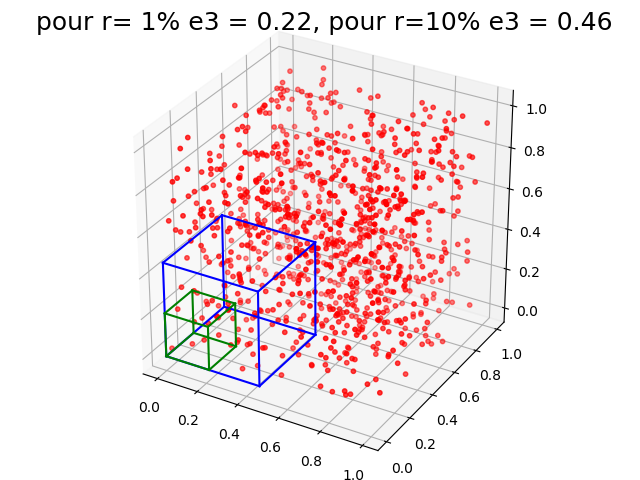

In [50]:
x=np.random.rand(1000)
y=np.random.rand(1000)
z=np.random.rand(1000)
fig = plt.figure()
ax = Axes3D(fig)

ax.set_aspect("equal")
ax.scatter(x,y, z, zdir='z', s=10, c='r')
#draw cube
rmax_1sur10=0.1**(1./3)
r = [0, rmax_1sur10]
for s, e in combinations(np.array(list(product(r,r,r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s,e), color="b")
rmax_1sur100=0.01**(1./3)
r = [0, rmax_1sur100]
for s, e in combinations(np.array(list(product(r,r,r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s,e), color="g")
ax.set_title(' pour r= 1%% e3 = %.2f, pour r=10%% e3 = %.2f'%(rmax_1sur100,rmax_1sur10),fontsize=18)        
